In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:
# Read in data
cleaned_df = pd.read_csv("cleaned_data_v2.csv")

In [ ]:
# Create DataFrame with fats columns, cholesterol, and organic label
cluster_df = cleaned_df[['fat_100g', 'saturated_fat_100g', 'cholesterol_100g', 'organic_label']]

In [ ]:
# Create new column to see if ratio of saturated fat to total fat has any correlation with organic labeling
cluster_df['sat_fat_to_total_fat'] = cluster_df['saturated_fat_100g'] / (cluster_df['fat_100g'] + 1e-6)

<ipython-input-4-a41499a65d4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['sat_fat_to_total_fat'] = cluster_df['saturated_fat_100g'] / (cluster_df['fat_100g'] + 1e-6)


In [ ]:
# Create features DataFrame
features = cluster_df[['fat_100g', 'saturated_fat_100g', 'cholesterol_100g', 'sat_fat_to_total_fat']]

In [ ]:
# Fill in nulls with 0s
features = features.fillna(0)

#### Correlation Matrix

In [ ]:
corr_matrix = features.corr()

###### Positive correlations between these features makes sense because they have direct relationships.

In [ ]:
corr_matrix

,fat_100g,saturated_fat_100g,cholesterol_100g,sat_fat_to_total_fat
fat_100g,1.000000,0.682825,0.179969,0.274082
saturated_fat_100g,0.682825,1.000000,0.382912,0.700780
cholesterol_100g,0.179969,0.382912,1.000000,0.392032
sat_fat_to_total_fat,0.274082,0.700780,0.392032,1.000000


Moderate positive correlation between saturated fat and saturated fat to total fat ratio indicates that as saturated fat increases, so does the ratio of saturated fat to total fat. This makes sense because foods with higher saturated fat levels are likely to have a larger proportion of their total fat content from saturated fat.

Moderate correlation between cholesterol_100g and sat_fat_to_total_fat suggests that foods with a higher proportion of saturated fat relative to total fat may also have more cholesterol.

Features for clustering:

*   fat_100g: general measure of total fat content, which is helpful for identifying high-calorie or processed foods

*   saturated_fat_100g: closely related to total fat but gives additional insight into the quality of the fat content because processed foods tend to have higher saturated fat

* cholesterol_100g: show levels of cholesterol since processed products tend to have more cholesterol

* sat_fat_to_total_fat: helps assess the quality of fats by showing the proportion of total fat that is saturated, higher ratio tends to lean towards non-organic foods

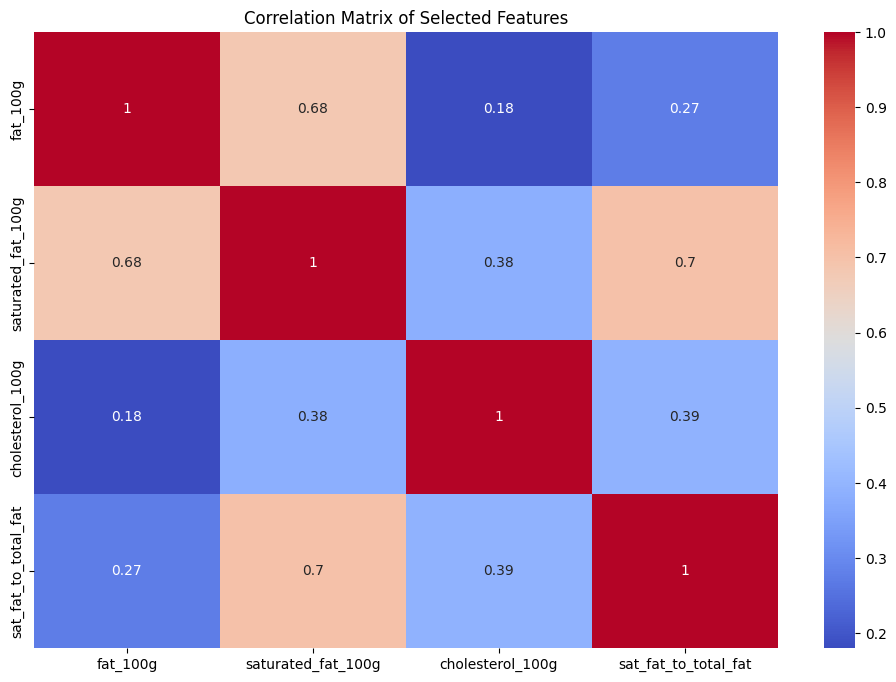

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Selected Features")
plt.show()

In [ ]:
# Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

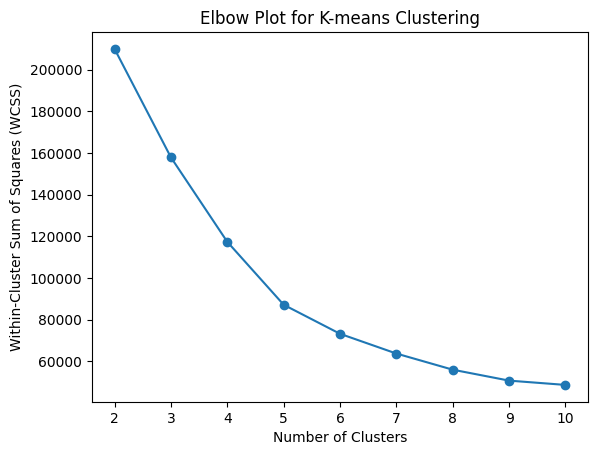

In [ ]:
# Create elbow plot to select number of clusters
wcss = []
k_range = range(2, 11)

for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, random_state=0)
  kmeans.fit(scaled_data)
  wcss.append(kmeans.inertia_)

plt.plot(k_range, wcss, marker='o', linestyle='-')
plt.title('Elbow Plot for K-means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

In [ ]:
# Fit model again on decided number of clusters
number_of_clusters = 5
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0)
clusters = kmeans.fit_predict(features)
cluster_df['cluster'] = clusters

<ipython-input-12-b23c09a356aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['cluster'] = clusters


###Cluster Profiles
#####Cluster 0: Low fat and saturated fat levels, possibly organic or minimally processed low-calorie foods. Lowest saturated fat to total fat ratio. Highest organic presence.
#####Cluster 1: Moderate to High in fat and saturated fat. Highest saturated fat to total fat ratio. Lowest organic presence, likely processed foods.
#####Cluster 2: High in fat, moderate in saturated fats. Likely a mix of processed foods.
#####Cluster 3: Moderate fat levels, likely a mix of processed foods.
#####Cluster 4: Moderate to High in fat, likely a mix of processed foods.

In [ ]:
# get averages of each feature for each cluster
cluster_summary = cluster_df.groupby('cluster')[['fat_100g', 'saturated_fat_100g', 'cholesterol_100g', 'sat_fat_to_total_fat']].mean()
print("Cluster Profiles:\n", cluster_summary)

Cluster Profiles:
           fat_100g  saturated_fat_100g  cholesterol_100g  sat_fat_to_total_fat
cluster                                                                       
0         1.907656            0.444072          0.006033              0.126035
1        26.211519           15.123116          0.031834              0.588932
2        47.201197            7.611828          0.006444              0.165386
3        13.212880            4.875003          0.022975              0.378916
4        27.099881            5.324106          0.014186              0.201707


In [ ]:
# get percentage of organic products in each cluster
organic_distribution = cluster_df.groupby('cluster')['organic_label'].mean()
print("Proportion of Organic Products in Each Cluster:\n", organic_distribution)

Proportion of Organic Products in Each Cluster:
 cluster
0    0.150338
1    0.068059
2    0.105112
3    0.102417
4    0.117071
Name: organic_label, dtype: float64


###Conclusion:
#####Cluster 1 has the lowest organic proportion and the highest saturated fat to total fat ratio, likely consisting of highly processed foods. Cluster 0 has the highest organic proportions and the lowest saturated fat to total fat ratio, likely consisting of healthier foods. Cluster 2, 3, and 4 are a mix of processed foods. There is a very slight correlation between the saturated fat vs. total fat ratio to organic labeling as the higher the ratio, the lower the organic proportion.

#####Overall, these clusters show that there is not a strong alignment between fat levels and organic labeling of products. Therefore, there is not a significant difference between organic and non-organic foods based on fat alone.